In [116]:
# [数据处理](https://www.kaggle.com/startupsci/titanic-data-science-solutions)
# 使用的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

# 模型
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [89]:
# 导入训练和测试数据
train_data = pd.read_csv('../data/titanic/train.csv',encoding='utf-8',iterator=False)
test_data = pd.read_csv('../data/titanic/test.csv',encoding='utf-8',iterator=False)

In [90]:
# 查看数据概况
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [91]:
# 缺失值统计
def get_missing_data_info(data):
    """
    获取缺失值统计
     Parameters
    ----------
    data : Series or DataFrame
        要统计的数据

    Returns
    -------
    Series or DataFrame
        统计总数和占比
    """
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    

In [92]:
missing_data = get_missing_data_info(train_data)
missing_data.head(10)


,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [93]:
# 分析缺失值
# Cabin 的缺失值达到了70%以上,删除
# Name 可以深度挖掘是否是富人,通过家族姓氏,这里我们先删除
# Ticket 船票号码可以深度挖掘是否靠窗等,这里我们先删除
# Age 的缺失值可以通过平均值的填充
# Embarked 的缺失值可以通过最高频率值来填充

# 删除Cabin
delete_columns = ['Cabin','Name','Ticket']
train_data.drop(delete_columns,axis=1,inplace=True)
test_data.drop(delete_columns,axis=1,inplace=True)

# 使用sklearn的impute来填充缺失值
mean_columns = ['Age','Fare']
impute_mean = SimpleImputer(missing_values=np.nan,strategy="mean")
train_data[mean_columns] = impute_mean.fit_transform(train_data[mean_columns])
test_data[mean_columns] = impute_mean.transform(test_data[mean_columns])

most_frequent_columns = ['Embarked']
impute_most_frequent = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
train_data[most_frequent_columns] = impute_most_frequent.fit_transform(train_data[most_frequent_columns])
test_data[most_frequent_columns] = impute_most_frequent.transform(test_data[most_frequent_columns])

In [94]:
# 数据归一化处理
scaler_columns = ['Age','Fare']

std_scaler = StandardScaler()
train_data[scaler_columns] = std_scaler.fit_transform(train_data[scaler_columns])
test_data[scaler_columns] = std_scaler.transform(test_data[scaler_columns])

In [95]:
# TODO: 异常值处理

In [96]:
# 分类数据编码
ont_hot_columns = ['Pclass','Sex','Embarked']
train_data = pd.get_dummies(train_data,columns=ont_hot_columns)
test_data = pd.get_dummies(test_data,columns=ont_hot_columns)

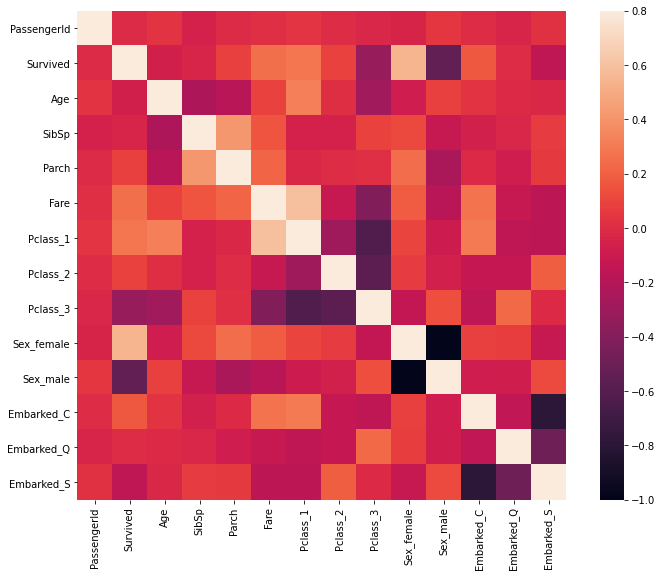

In [97]:
# 相关系数分析
corrmat = train_data.corr()
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,square=True,vmax=.8)
# 从图上可以看出来,性别和存活有关系

Index(['Survived', 'Sex_female', 'Pclass_1', 'Fare', 'Embarked_C', 'Pclass_2',
       'Parch', 'Embarked_Q', 'PassengerId', 'SibSp'],
      dtype='object')


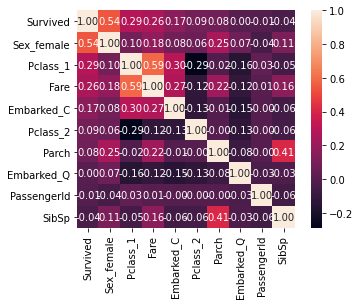

In [98]:
# 选取10个最相关的特征
k = 10
cols = corrmat.nlargest(k,'Survived')['Survived'].index
print(cols)
cm = np.corrcoef(train_data[cols].values.T)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':10},yticklabels=cols.values,xticklabels=cols.values)

In [99]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   Pclass_1     891 non-null    uint8  
 7   Pclass_2     891 non-null    uint8  
 8   Pclass_3     891 non-null    uint8  
 9   Sex_female   891 non-null    uint8  
 10  Sex_male     891 non-null    uint8  
 11  Embarked_C   891 non-null    uint8  
 12  Embarked_Q   891 non-null    uint8  
 13  Embarked_S   891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(8)
memory usage: 48.9 KB


In [100]:
# 删除没用的数据
y_train,X_train = train_data['Survived'].values,train_data.drop(['PassengerId','Survived'],axis=1).values

X_test = test_data.drop(['PassengerId'],axis=1).values

In [101]:
# 构建最好参数的模型
scoring = make_scorer(accuracy_score, greater_is_better=True)

def get_model(estimator, parameters, X_train, y_train, scoring):  
    model = GridSearchCV(estimator, param_grid=parameters, scoring=scoring)
    model.fit(X_train, y_train)
    return model.best_estimator_


In [102]:
# 以KNN为例
knn = KNeighborsClassifier(weights='uniform')
parameters = {'n_neighbors':[i for i in range(2,15)], 'p':[1,2]}
clf_knn = get_model(knn,parameters=parameters,X_train=X_train,y_train=y_train,scoring=scoring)

In [103]:
# 打印学习曲线
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/home/meng/workspace/python/ML-DL-Example/venv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

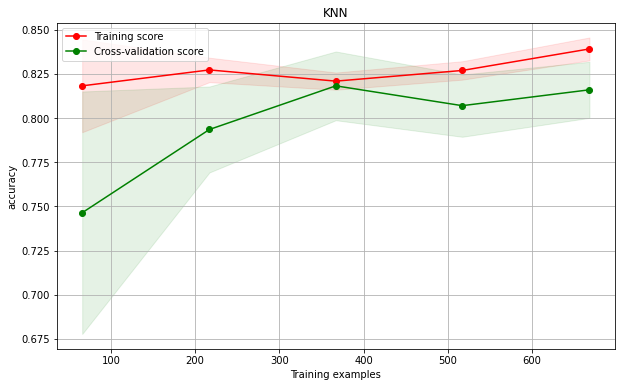

In [104]:
# 预测
plot_learning_curve(clf_knn, 'KNN', X_train, y_train, cv=4)

<module 'matplotlib.pyplot' from '/home/meng/workspace/python/ML-DL-Example/venv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

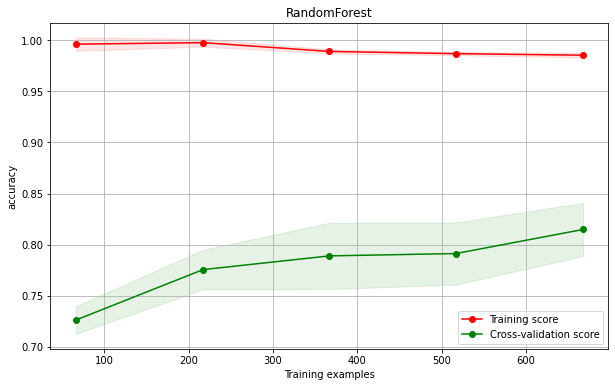

In [123]:
rfc = RandomForestClassifier()
parameters = {'n_estimators':np.linspace(20,200,6,dtype=np.int)}
clf_rfc = get_model(rfc,parameters=parameters,X_train=X_train,y_train=y_train,scoring=scoring)
plot_learning_curve(clf_rfc, 'RandomForest', X_train, y_train, cv=4)

<module 'matplotlib.pyplot' from '/home/meng/workspace/python/ML-DL-Example/venv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

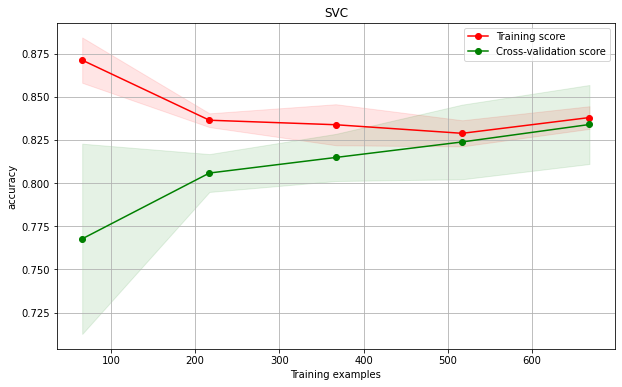

In [114]:
svc = SVC()
parameters = {'kernel':['linear','rbf']}
clf_svc = get_model(svc,parameters=parameters,X_train=X_train,y_train=y_train,scoring=scoring)
plot_learning_curve(clf_svc, 'SVC', X_train, y_train, cv=4)

In [118]:
# 把几个分类器集成起来
clf_vc = VotingClassifier(estimators=[('svc', clf_svc), 
                                      ('rfc', clf_rfc), ('knn', clf_knn)], 
                          voting='hard', weights=[4,4,2])
clf_vc = clf_vc.fit(X_train, y_train)



<bound method ClassifierMixin.score of VotingClassifier(estimators=[('svc',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('rfc',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='g...
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
            

In [124]:
# 预测
pred = clf_rfc.predict(X_test)
pred

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [125]:
# 生成预测文件
pred_data = pd.DataFrame({'PassengerId':test_data.PassengerId,'Survived':pred})

pred_data.to_csv("../data/titanic/submission.csv",index=False)